In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gpflow
import tensorflow as tf
from gpflow.kernels import SquaredExponential as SE
from gpflow.kernels import RationalQuadratic as RQ
from gpflow.kernels import Linear, Periodic

In [2]:
import sys
from gpflow.ci_utils import ci_niter
sys.path.append('../code')
from gplar import GPLARegressor
from gpar.regression import GPARRegressor

In [8]:
def generate_synthetic_data(kernels, N_train, N_test, noise, xmin=-3, xmax=3):
    x = np.linspace(xmin, xmax, 1000).reshape(-1,1)
    idx = np.random.choice(1000,N_train+N_test,replace=False)
    idx_train, idx_test = idx[:N_train], idx[N_train:]
    inputx = x
    output, test, true = [],[],[]
    plt.figure(figsize=(20, len(kernels)*3))
    for i in range(len(kernels)):
        Kx = kernels[i](inputx)
        h = np.random.multivariate_normal(np.zeros(1000), Kx)[:,None]
        hh = h[idx_train]
        hh_test = h[idx_test]
        y = hh + np.random.normal(0,noise[i],N_train).reshape(-1,1)
        y_test = hh_test + np.random.normal(0,noise[i],N_test).reshape(-1,1)
        plt.subplot(len(kernels),1, i+1)
        plt.scatter(x[idx_train], y, c='black', label='Train', s=10)
        plt.scatter(x[idx_test], y_test, c='red', label='Test', s=10)
        plt.plot(x, h)
        plt.ylabel('output '+str(i))
        
        inputx = np.concatenate((inputx, h), axis=1)
        output.append(y)
        true.append(h)
        test.append(y_test)
    return x[idx_train], np.stack(output,axis=1)[:,:,0], \
            x, np.stack(true,axis=1)[:,:,0],\
            x[idx_test], np.stack(test, axis=1)[:,:,0]

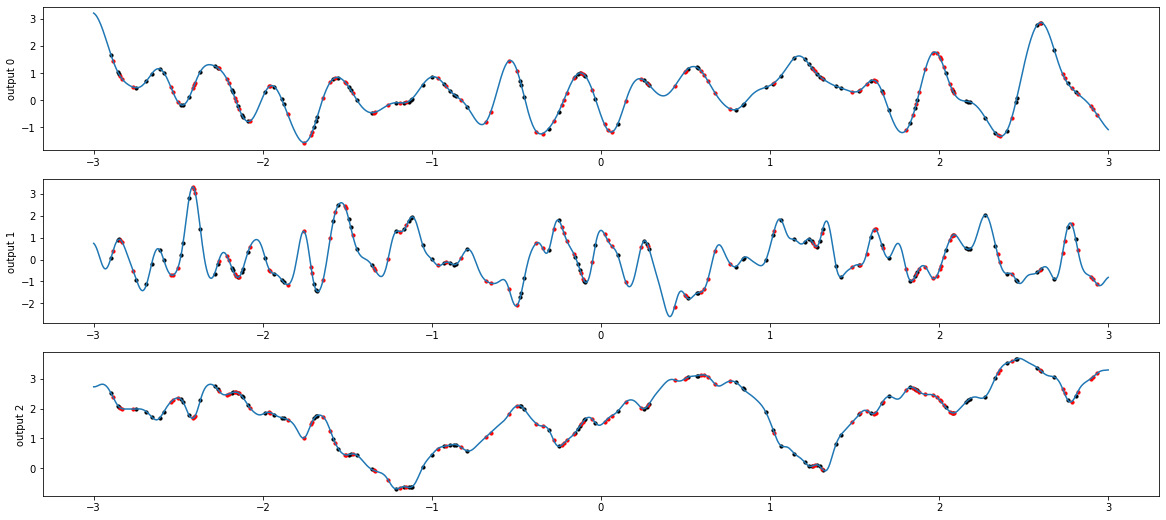

In [9]:
kernels_se = [SE(active_dims=[0],variance=1.,lengthscales=0.1),
           SE(active_dims=[0],variance=1.,lengthscales=0.1)
               +SE(active_dims=[1],variance=1.,lengthscales=2.),
           SE(active_dims=[0],variance=1.,lengthscales=0.1)
               +SE(active_dims=[1,2],variance=1.,lengthscales=[2.,3.]),
           SE(active_dims=[0],variance=1.,lengthscales=0.1)
               +SE(active_dims=[1,2,3],variance=1.,lengthscales=[2.,3.,2.]),
           SE(active_dims=[0],variance=1.,lengthscales=0.1)
               +SE(active_dims=[1,2,3,4],variance=1.,lengthscales=[2.,2.,3.,3.])]

kernels_se = [SE(active_dims=[0],variance=1.,lengthscales=0.1),
           SE(active_dims=[0],variance=1.,lengthscales=0.05)
               +SE(active_dims=[1],variance=1.,lengthscales=10.),
           SE(active_dims=[0],variance=1.,lengthscales=0.2)
               +SE(active_dims=[1,2],variance=1.,lengthscales=[10.,5.])]

kernels_linear = [SE(active_dims=[0],variance=1.,lengthscales=0.1),
           SE(active_dims=[0],variance=1.,lengthscales=0.2)
               +Linear(active_dims=[1],variance=1.),
           SE(active_dims=[0],variance=1.,lengthscales=0.05)
               +Linear(active_dims=[1,2],variance=[5.,1.]),
           SE(active_dims=[0],variance=1.,lengthscales=0.02)
               +Linear(active_dims=[1,2,3],variance=[1.,5.,2.]),
           SE(active_dims=[0],variance=1.,lengthscales=0.1)
               +Linear(active_dims=[1,2,3,4],variance=[1.,3.,2.,5.])]

x_train, y_train, x_, h_, x_test, y_test = generate_synthetic_data(kernels_se, 100, 100, [0.0]*10)

In [15]:
def meanstd(y):
    mean, std = [],[]
    for i in range(y.shape[1]):
        available = ~np.isnan(y[:,i])
        y_i = y[available,i]
        mean.append(np.mean(y_i))
        std.append(np.std(y_i))
    return np.stack(mean), np.stack(std)

mean, std = meanstd(y_train)
y_train_norm = (y_train-mean)/std

In [16]:
gpar = GPARRegressor(scale=0.1,
                          linear=True,linear_scale=2.0,
                          nonlinear=False,
                          noise=0.1,
                          impute=True, replace=True, normalise_y=False)
M = 100

gplar = GPLARegressor(x_train, y_train_norm, M, gpar,
                            white=False,
                            scale=0.1,
                            linear=True, linear_scale=2.0,
                            nonlinear=False,
                            noise_inner=1e-5, noise_obs=0.1,
                            num_samples=1)

In [17]:
@tf.function(autograph=False)
def optimization_step(optimizer, model, data):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        objective = -model.maximum_log_likelihood_objective(*data)
        grads = tape.gradient(objective, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    return objective

def run_adam(model, data, iterations):
    logf = []
    adam = tf.optimizers.Adam(0.001)
    for step in range(iterations):
        neg_elbo= optimization_step(adam, model, data)
        elbo = -neg_elbo
        if step%100 == 0:
            logf.append(elbo.numpy())
        if step%1000 == 0:
            print(elbo.numpy())
    return logf

maxiter = ci_niter(10000)
logf = run_adam(gplar, (x_train, y_train_norm), maxiter)

-15873.108295208072
-309.3426454985162
-173.37371197558986
-105.69440791873475
-58.67279170934705
-17.014336776636128
14.785799570572067
38.738844484398555
44.70587070855788
55.80275673859069


In [18]:
Hmeans_c, Hvars_c = gplar.predict_f(x_, 100)
observation_variance = []
for i in range(y_train.shape[1]):
    observation_variance.append(gplar.likelihoods[i].variance.value().numpy())
observation_var = np.array(observation_variance)

def getMeanandBound(Hmeans,Hvars,y_mean,y_std):
    Hmeans, Hvars = np.squeeze(np.stack(Hmeans, axis=2)), np.squeeze(np.stack(Hvars,axis=2))
    mean, var = np.mean(Hmeans,axis=0), np.mean(Hvars, axis=0)
    mean, std = mean*y_std + y_mean, y_std*np.sqrt(var+observation_var)
        
    return mean, mean-1.96*std, mean+1.96*std
predict_y = getMeanandBound(Hmeans_c, Hvars_c, mean, std)

In [10]:
gpar = GPARRegressor(scale=0.1,
                          linear=True,linear_scale=2.0,
                          nonlinear=False,
                          noise=0.1,
                          impute=True, replace=True, normalise_y=True)
gpar.fit(x_train, y_train)
means_gpar, lowers_gpar, uppers_gpar = \
        gpar.predict(x_, num_samples=100, credible_bounds=True, latent=True)

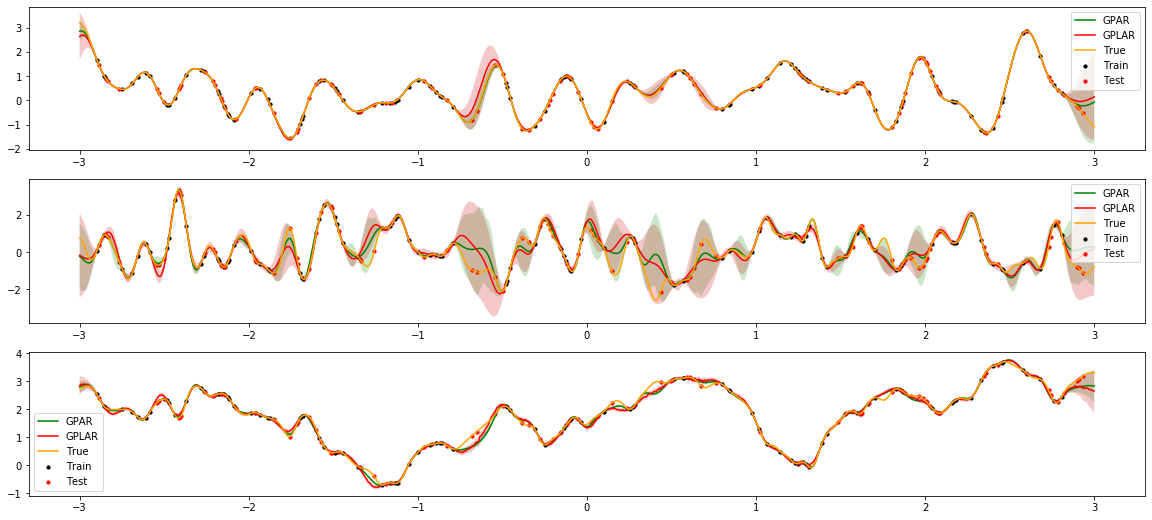

In [19]:
fig = plt.figure(figsize=(20, y_train.shape[1]*3))
for i in range(y_train.shape[1]):
    plt.subplot(y_train.shape[1],1,i+1)
    plt.plot(x_, means_gpar[:,i], c='green', label='GPAR')
    plt.fill_between(x_[:,0], lowers_gpar[:, i], uppers_gpar[:, i], facecolor='tab:green', alpha=.25)
    
    plt.plot(x_, predict_y[0][:,i], c='red', label = 'GPLAR')
    plt.fill_between(x_[:,0], predict_y[1][:, i], predict_y[2][:, i], facecolor='tab:red', alpha=.25)
    
    plt.scatter(x_train, y_train[:,i], c='black', label='Train', s=10)
    plt.scatter(x_test, y_test[:,i], c='red', label='Test', s=10)
    plt.plot(x_, h_[:,i], c='orange', label = 'True')
    plt.legend()
#fig.savefig('noise-0.1.png',dpi=500)

In [28]:
def predict_log_density(model, x, y, num_samples, full_cov=False):
    Hmean, Hvar = model._predict(x, full_cov=full_cov, S=num_samples)
    log_density = []
    for i in range(y.shape[1]):
        Y = y[:,i]
        mu = Hmean[i][:,:,0] * std[i] + mean[i]
        var = Hvar[i][:,:,0] * std[i]**2 + model.likelihoods[i].variance
        print(np.mean(var, axis=0))
        l = -0.5*(np.log(2*np.pi)+np.log(var)+np.square(Y - mu)/var)
        log_num_samples = tf.math.log(tf.cast(num_samples, l.dtype))
        log_likelihood = tf.reduce_sum(tf.reduce_logsumexp(l - log_num_samples, axis=0))
        log_density.append(log_likelihood.numpy())
    return log_density

def predict_log_density_gpar(model, x, y, num_samples):
    samples = model.sample(x, num_samples=num_samples, latent=True, posterior=True)
    means, vars = np.mean(samples,axis=0), np.var(samples,axis=0)
    log_density = []
    for i in range(y.shape[1]):
        Y = y[:,i]
        mu, var = means[:,i], vars[:,i]
        log_likelihood = -0.5*(np.log(2*np.pi)+np.log(var)+np.square(Y - mu)/var)
        log_density.append(np.sum(log_likelihood))
    return log_density

In [14]:
gpar  = GPARRegressor(scale=0.1,
                  linear=False,
                  nonlinear=True, nonlinear_scale=5.,
                  noise=0.05,
                  impute=True, replace=True, normalise_y=True)
gpar.fit(x_train,y_train)
predict_log_density_gpar(gpar, x_test, y_test, 100)

[[3.71388453e-04 4.68095461e-02 1.12594420e-07]
 [9.06386586e-08 4.31219009e-03 1.87623513e-08]
 [4.09249043e-07 1.72437118e-03 1.71373277e-08]
 [6.90812050e-07 1.35766194e-03 3.29974842e-08]
 [4.38819174e-05 2.26660020e-01 9.17810340e-08]
 [9.04488942e-08 4.20216114e-03 2.56350393e-08]
 [1.14729415e-04 4.77449160e-01 1.62159799e-07]
 [2.33917081e-08 6.81684954e-06 8.50739123e-09]
 [2.94531528e-08 5.49402113e-04 8.00885664e-09]
 [6.73521120e-09 7.45171333e-08 3.54593875e-09]
 [3.93344843e-07 8.02783090e-03 1.11072660e-08]
 [6.73019949e-07 8.23661944e-04 1.55519644e-08]
 [2.24536071e-08 6.70071924e-05 8.20386876e-09]
 [1.76866777e-04 1.01492076e-01 8.46994740e-08]
 [3.61552760e-06 1.32159659e-02 4.04844151e-08]
 [2.65504470e-08 2.08364843e-04 1.28796903e-08]
 [1.27814535e-04 1.76487265e-02 4.86869452e-08]
 [3.47986210e-07 1.99657292e-02 2.94458453e-08]
 [9.47472609e-09 1.08796761e-04 1.00405113e-08]
 [1.38710977e-07 7.49863282e-03 2.14366992e-08]
 [4.98246053e-09 5.78944458e-07 4.303027

[524.6542104974349, 98.63325396350118, -3329443.1984368125]

In [26]:
predict_log_density(gplar, x_test, y_test, 100)

[8.95460580e-04 6.17264716e-05 1.24880046e-04 1.22631028e-04
 5.87275817e-04 7.36202945e-05 1.41343052e-03 5.60212915e-05
 4.63629969e-05 3.63621054e-05 4.74387250e-05 7.57154635e-05
 5.25579324e-05 2.28948383e-03 2.00935326e-04 5.94370211e-05
 3.68653624e-04 5.44597828e-05 4.97627352e-05 4.95008105e-05
 3.71762793e-05 6.18321843e-05 1.51966701e-01 8.83261820e-04
 1.39117509e-04 2.45022670e-01 5.34305202e-05 3.83554402e-05
 5.31072338e-05 1.52697845e-04 1.06337611e-04 2.44753097e-03
 1.72166943e-04 5.10771654e-05 5.24826217e-05 6.08281054e-05
 1.08900634e-04 4.89061164e-05 1.54144279e-04 3.75146963e-05
 1.04445850e-04 2.04688388e-04 4.28857272e-01 4.14199730e-05
 3.66559827e-03 3.68752266e-05 5.04725744e-05 9.90238017e-05
 3.10808210e-02 4.02925219e-05 1.21920790e-02 3.24508414e-03
 5.41981005e-05 3.98467890e-05 5.38562993e-05 9.11838577e-05
 3.88586025e-05 3.84955312e-05 4.97198707e-05 1.53340778e-03
 3.99164520e-05 1.02561826e-04 4.55726500e-05 4.76094453e-05
 4.72492020e-05 1.767032

[313.1992185678533, -0.9739292435807299, 117.7069587195142]

## noise = 0.1

SE kernel over inputs + ARD SE kernels over outputs

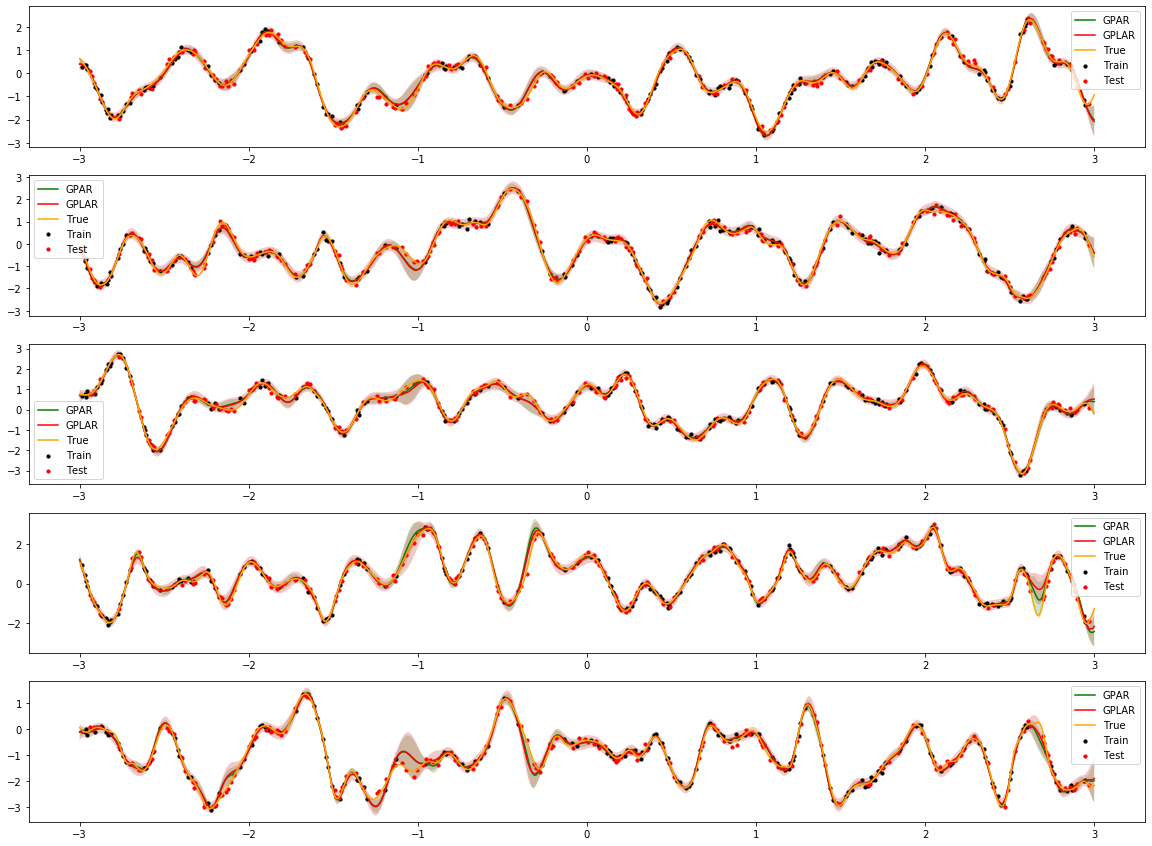

In [83]:
fig = plt.figure(figsize=(20, y_train.shape[1]*3))
for i in range(y_train.shape[1]):
    plt.subplot(y_train.shape[1],1,i+1)
    plt.plot(x_, means_gpar[:,i], c='green', label='GPAR')
    plt.fill_between(x_[:,0], lowers_gpar[:, i], uppers_gpar[:, i], facecolor='tab:green', alpha=.25)
    
    plt.plot(x_, predict_y[0][:,i], c='red', label = 'GPLAR')
    plt.fill_between(x_[:,0], predict_y[1][:, i], predict_y[2][:, i], facecolor='tab:red', alpha=.25)
    
    plt.scatter(x_train, y_train[:,i], c='black', label='Train', s=10)
    plt.scatter(x_test, y_test[:,i], c='red', label='Test', s=10)
    plt.plot(x_, h_[:,i], c='orange', label = 'True')
    plt.legend()
fig.savefig('noise-0.1.png',dpi=500)

In [81]:
predict_log_density(gplar, x_test, y_test, 100)

[[0, 115.0515078477695],
 [1, 120.2679137024858],
 [2, 128.20531126147102],
 [3, 107.39665964229394],
 [4, 102.31858467211977]]

In [82]:
predict_log_density_gpar(gpar, x_test, y_test, 100)

Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


[[0, -51.6043311052615],
 [1, 11.258958579577698],
 [2, 12.329772623282704],
 [3, 31.781997886524284],
 [4, -73.87658906831882]]

## noise = 0.5
SE kernel over inputs + ARD SE kernels over outputs

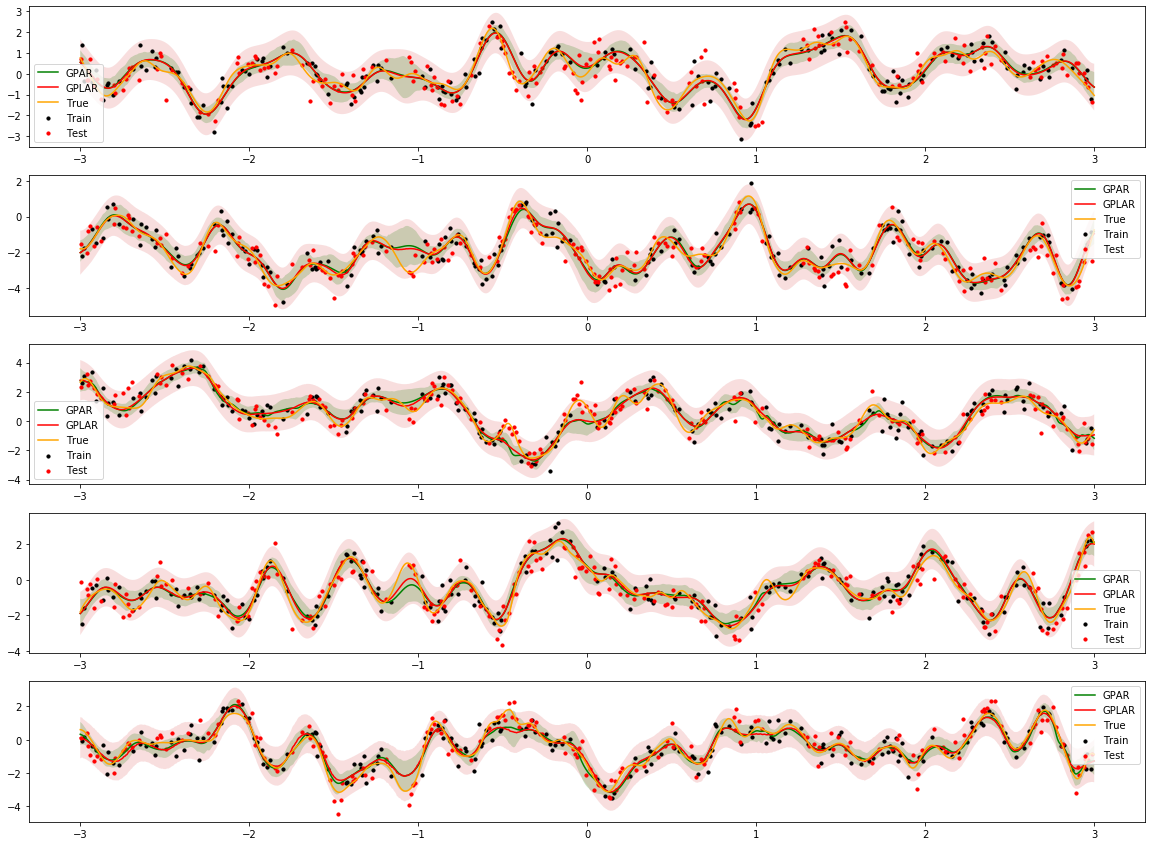

In [94]:
fig = plt.figure(figsize=(20, y_train.shape[1]*3))
for i in range(y_train.shape[1]):
    plt.subplot(y_train.shape[1],1,i+1)
    plt.plot(x_, means_gpar[:,i], c='green', label='GPAR')
    plt.fill_between(x_[:,0], lowers_gpar[:, i], uppers_gpar[:, i], facecolor='tab:green', alpha=.25)
    
    plt.plot(x_, predict_y[0][:,i], c='red', label = 'GPLAR')
    plt.fill_between(x_[:,0], predict_y[1][:, i], predict_y[2][:, i], facecolor='tab:red', alpha=.15)
    
    plt.scatter(x_train, y_train[:,i], c='black', label='Train', s=10)
    plt.scatter(x_test, y_test[:,i], c='red', label='Test', s=10)
    plt.plot(x_, h_[:,i], c='orange', label = 'True')
    plt.legend()
fig.savefig('noise-0.5.png',dpi=500)

In [92]:
predict_log_density(gplar, x_test, y_test, 100)

[[0, -186.4698433378645],
 [1, -196.62065941878737],
 [2, -217.75209014001388],
 [3, -208.1967734790877],
 [4, -186.1803802254144]]

In [93]:
predict_log_density_gpar(gpar, x_test, y_test, 100)

Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


[[0, -588.1492462590855],
 [1, -463.7160223651247],
 [2, -504.7013474011036],
 [3, -483.77712813635975],
 [4, -357.4314679216337]]

## Different Noise Level = [0.1,0.2,0.1,0.5,0.1]

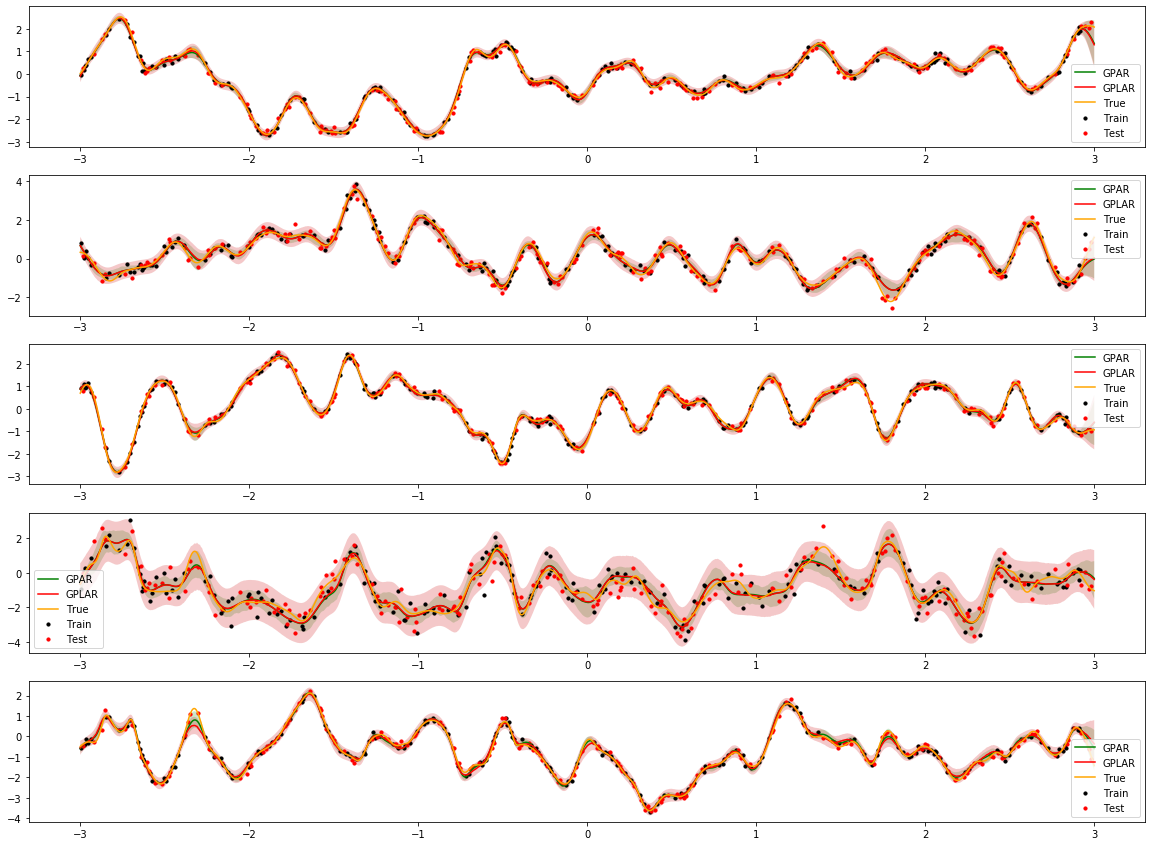

In [103]:
fig = plt.figure(figsize=(20, y_train.shape[1]*3))
for i in range(y_train.shape[1]):
    plt.subplot(y_train.shape[1],1,i+1)
    plt.plot(x_, means_gpar[:,i], c='green', label='GPAR')
    plt.fill_between(x_[:,0], lowers_gpar[:, i], uppers_gpar[:, i], facecolor='tab:green', alpha=.25)
    
    plt.plot(x_, predict_y[0][:,i], c='red', label = 'GPLAR')
    plt.fill_between(x_[:,0], predict_y[1][:, i], predict_y[2][:, i], facecolor='tab:red', alpha=.25)
    
    plt.scatter(x_train, y_train[:,i], c='black', label='Train', s=10)
    plt.scatter(x_test, y_test[:,i], c='red', label='Test', s=10)
    plt.plot(x_, h_[:,i], c='orange', label = 'True')
    plt.legend()
fig.savefig('noise-different.png',dpi=500)

In [104]:
predict_log_density(gplar, x_test, y_test, 100)

[[0, 131.94202694137488],
 [1, -9.867645389533532],
 [2, 145.02148823391744],
 [3, -176.22265497438235],
 [4, 90.90752421027463]]

In [105]:
predict_log_density_gpar(gpar, x_test, y_test, 100)

Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


[[0, 8.70326498740191],
 [1, -188.40179574108535],
 [2, 51.405467227661305],
 [3, -349.9732004478396],
 [4, 6.41633549111296]]

SE kernel over inputs + ARD Linear kernels over outputs

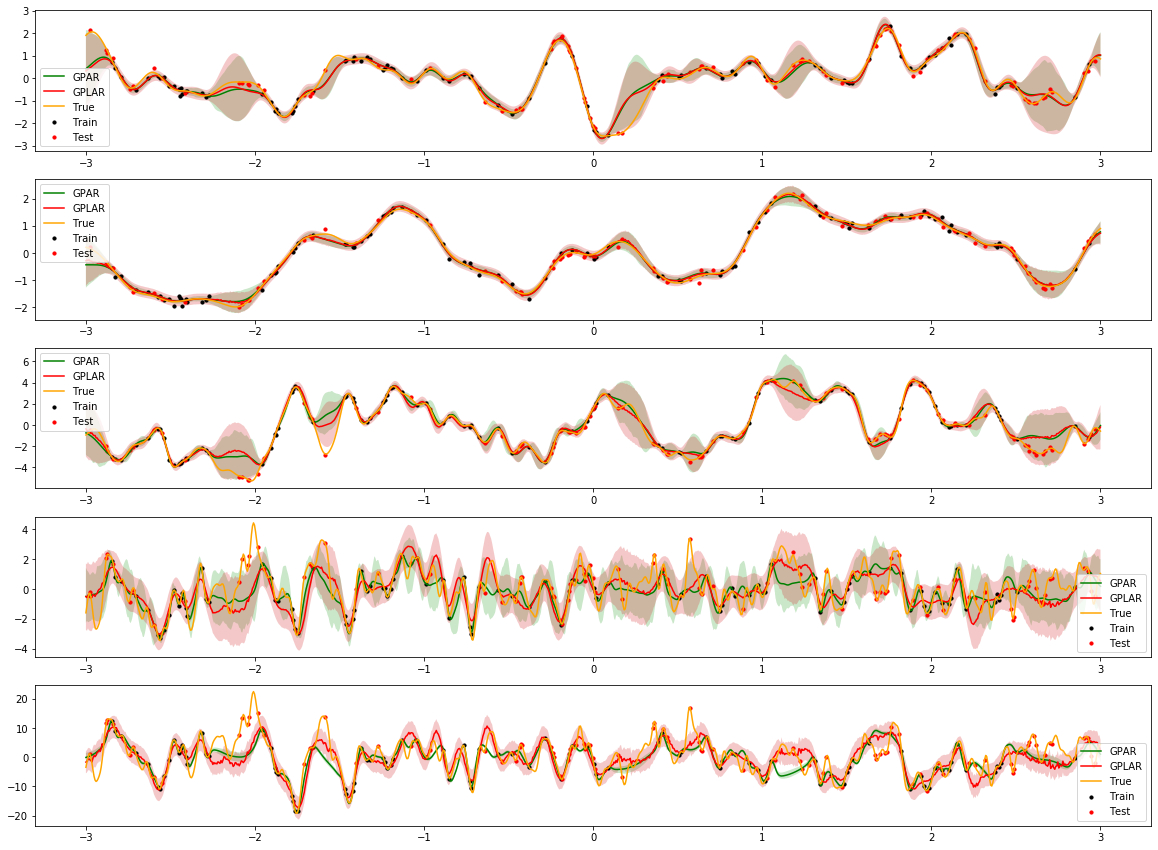

In [18]:
fig = plt.figure(figsize=(20, y_train.shape[1]*3))
for i in range(y_train.shape[1]):
    plt.subplot(y_train.shape[1],1,i+1)
    plt.plot(x_, means_gpar[:,i], c='green', label='GPAR')
    plt.fill_between(x_[:,0], lowers_gpar[:, i], uppers_gpar[:, i], facecolor='tab:green', alpha=.25)
    
    plt.plot(x_, predict_y[0][:,i], c='red', label = 'GPLAR')
    plt.fill_between(x_[:,0], predict_y[1][:, i], predict_y[2][:, i], facecolor='tab:red', alpha=.25)
    
    plt.scatter(x_train, y_train[:,i], c='black', label='Train', s=10)
    plt.scatter(x_test, y_test[:,i], c='red', label='Test', s=10)
    plt.plot(x_, h_[:,i], c='orange', label = 'True')
    plt.legend()
fig.savefig('Linear-output.png',dpi=500)

In [19]:
predict_log_density(gplar, x_test, y_test, 100)

[[0, 20.720933709413504],
 [1, 75.35366369077204],
 [2, -52.70800961350605],
 [3, -177.8326386257985],
 [4, -480.75101636007145]]

In [20]:
predict_log_density_gpar(gpar, x_test, y_test, 100)

Sampling (total: 100): 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100


[[0, 9.756815966813068],
 [1, 64.61850235452806],
 [2, -55.34289348857973],
 [3, -147.81169683518374],
 [4, -7253.862283620471]]